In [1]:
import numpy as np

f = open("Annotations.txt", "r")
print(f.read())

with open(r"Annotations.txt", "r+") as f: 
    data = f.readlines() 
    Ano_mass=[]
    Ano_charge = []
    Ano = []
for x in data:
    Ano_mass.append(x.split('\t')[1])
    Ano_charge.append(x.split('\t')[3])
    Ano.append(x.split('\t')[0])
f.close()

Ano_mass.pop(0)
Ano_charge.pop(0)
Ano.pop(0)

positive_mode = 1
negative_mode = 0

if negative_mode:
    Ano_mass = Ano_mass[20:42]
    Ano_charge = Ano_charge[20:42]
    Ano = Ano[20:42]

if positive_mode:
    Ano_mass = Ano_mass[0:20] + Ano_mass[23:42]
    Ano_charge = Ano_charge[0:20] + Ano_charge[23:42]
    Ano = Ano[0:20] + Ano[23:42]

Ano_mass = np.array(Ano_mass)
Ano_mass = Ano_mass.astype('float')
Ano_charge = np.array(Ano_charge) 
Ano_charge = Ano_charge.astype('float')

Annotation	Mass	Mode	Charge	Tier
H	1.007276	Positive	1	1
2H	2.014552	Positive	2	1
3H	3.021828	Positive	3	1
NH4+	18.033823	Positive	1	2
Na	22.989218	Positive	1	1
H+Na	23.996494	Positive	2	1
2H+Na	25.003770	Positive	3	1
K	38.963158	Positive	1	2
H+K	39.970434	Positive	2	2
2H+K	40.977710	Positive	3	2
2Na	45.978436	Positive	2	1
H+2Na	46.985712	Positive	3	1
Na+K	61.952376	Positive	2	2
H+Na+K	62.959652	Positive	3	2
3Na	68.967654	Positive	3	1
2K	77.926316	Positive	2	2
H+2K	78.933592	Positive	3	2
2Na+K	84.941594	Positive	3	2
Na+2K	100.915534	Positive	3	2
3K	116.889474	Positive	3	2
H	-1.007276	Negative	-1	1
Cl-	34.969402	Negative	-1	1
COOH-	44.998201	Negative	-1	1
H2O+CO	-46.005479	Both	0	1
NH3+H2O	-35.037114	Both	0	1
H2O	-18.010565	Both	0	1
NH3	-17.026549	Both	0	1
Na-H	21.981945	Both	0	1
MeOH	32.026215	Both	0	1
K-H	37.955882	Both	0	1
Acetonitrile	41.026549	Both	0	1
2Na-2H	43.963890	Both	0	1
HCOOH	46.005479	Both	0	1
NaCl	57.958622	Both	0	1
3Na-3H	65.945835	Both	0	1
NaCOOH	67.987424	Both	0	1
KCOO

Bin -  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Binmass - [125.039, 111.023, 139.018, 149.003, 167.013, 121.008, 163.977, 191.972, 104.964, 132.958, 150.969, 141.959, 149.961, 90.948, 113.964, 125.096, 153.127, 177.956, 241.216, 265.253]


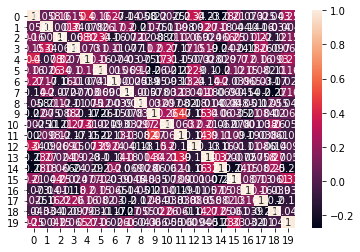

Cluster -  [1 2 1 2 1 1 1 2 2 2 2 2 1 2 2 1 1 1 2 1]
Number of cluster = 2
cnt = 10
[0, 2, 4, 5, 6, 12, 15, 16, 17, 19]
There5
There52


AttributeError: 'float' object has no attribute 'astype'

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from matplotlib.backends.backend_pdf import PdfPages
import scipy.cluster.hierarchy as spc
from scipy.stats import pearsonr
from sklearn import metrics


def getDataFrame():
    df = pd.read_csv("Stats_task2_40samp.csv")
    return df


class Data:
    def __init__(self,ID, mz, rt, intensity, MS1_count, MS2_triggered, Ion_Type, Annotation1, Similarity_Score1, Annotation2, Similarity_Score2, Annotation3, Similarity_Score3, MS2_Fragments, MS2_Intensities):
        self.ID = ID
        self.mz = mz
        self.rt = rt
        self.i = intensity
        self.MS1 = MS1_count
        self.MS2 = MS2_triggered
        self.ion = Ion_Type
        self.a1 = Annotation1
        self.score1 = Similarity_Score1
        self.a2 = Annotation2
        self.score2 = Similarity_Score2
        self.a3 = Annotation3
        self.score3 = Similarity_Score3
        self.ms2frag = MS2_Fragments
        self.ms2int = MS2_Intensities


    
    def calculateMeanIntensity(self):
        self.meanIntensity = sum(self.i)/len(self.i)

    def calculateMedIntensity(self):
        self.medIntensity = np.median([x for x in self.i])
        
    def Annotate(self, string):
        self.anno = string
        
    def bin_Num(self, x):
        self.bin = x
        
    def clust_Num(self, x):
        self.cluster = x
        
    def isotope(self, string):
        self.iso = string
        
    def determine_ISF(self, string):
        self.ISF = string
        
def dot_and_reverse_dot(refer_abd, refer_frag, calc_abd, calc_frag, ms2_frag_error = 0.01):
    '''
    Calculates the dot product between two sets. Takes one set as the reference and gives the dot product similarity
    When we will interchange the reference point, the same will get refered to reverse dot product value

    Parameters
    -------------
    refer_abd: A NumPy array of intensities taken as reference
    refer_frag: A NumPy array of fragments taken as reference
    calc_abd: A NumPy array of intensities of other set
    calc_frag: A NumPy array of fragments of other set
    ms2_frag_error: The error to considered for matching the fragments and for calculations

    Returns
    -----------
    The dot product value
    '''
    ## create dictionary
    refer_abd = refer_abd / np.amax(refer_abd)
    calc_abd = calc_abd / np.amax(calc_abd)
    s1 = np.sum(refer_abd)
    s1 = s1 - 0.5
    refer_w = s1 / (s1 + refer_abd)
    s2 = np.sum(calc_abd)
    s2 = s2 - 0.5
    calc_w = s2 / (s2 + calc_abd)
    ## We got the weights of the pattern
    refer_w_dict = dict(zip(refer_frag.tolist(), refer_w.tolist()))
    refer_abd_dict = dict(zip(refer_frag.tolist(), refer_abd.tolist()))
    calc_w_dict = dict(zip(calc_frag.tolist(), calc_w.tolist()))
    calc_abd_dict = dict(zip(calc_frag.tolist(),calc_abd.tolist()))
    a = 0.0
    b = 0.0
    c = 0.0
    refer_frag = np.sort(refer_frag)
    calc_frag = np.sort(calc_frag)
    for i in range(len(refer_frag)):
        if refer_frag[i] >= calc_frag[0] - ms2_frag_error and refer_frag[i] <= calc_frag[-1] + ms2_frag_error:
            val = find_nearest(calc_frag, refer_frag[i])
            if math.fabs(refer_frag[i] - val) <= ms2_frag_error:
                a += refer_w_dict[refer_frag[i]]*refer_abd_dict[refer_frag[i]]*calc_w_dict[val]*calc_abd_dict[val]
                c += (calc_w_dict[val]*calc_abd_dict[val])**2
            b += (refer_w_dict[refer_frag[i]]*refer_abd_dict[refer_frag[i]])**2
        else:
            b += (refer_w_dict[refer_frag[i]]*refer_abd_dict[refer_frag[i]])**2
    ## Got all the terms
    a = a**2
    if c == 0:
        return 0
    dt = a / (b*c)
    return dt


def getData():
    df = getDataFrame()
    dfValues = df.values.tolist()
    data = list()
    for i in range(len(dfValues)):
        data.append(Data(dfValues[i][0], dfValues[i][1], dfValues[i][2], [j for j in dfValues[i][12:52]], dfValues[i][3], dfValues[i][4], dfValues[i][5], dfValues[i][6], dfValues[i][7], dfValues[i][8], dfValues[i][9], dfValues[i][10], dfValues[i][11], dfValues[i][334], dfValues[i][335]))
    return data

def create_df(i,j):
    temp = list()
    col = list()
    for x in range(i,j):
        temp.append(data[x].i)
        col.append(x)
    df = pd.DataFrame(temp)
    df.set_axis(col, axis=0, inplace=True)
    return df.T



if __name__ == "__main__":
    data = getData()
    for i in range(len(data)):
        data[i].calculateMeanIntensity()
    
    flag = 0
    # Counting number of zero intensity 
    # and removing feature with greater than 30% zeroes
    
    i=0
    while(i<len(data)):
        cnt=0
        for j in range(0,40):
            if data[i].i[j]==0:
                cnt = cnt+1
        if cnt>12:
            del data[i]
        else:
            i = i+1
            
    
    #replace missing value with median intensity
    # and taking log transformation
    for i in range(len(data)):
        data[i].calculateMedIntensity()
        
    
    for i in range(len(data)):
        for j in range(0,40):
#             if data[i].i[j] == 0:
#                 data[i].i[j] = data[i].medIntensity
            data[i].i[j] = np.log10(1 + data[i].i[j])
#             else:
#                 data[i].i[j] = np.log10(1 + data[i].i[j])
                
    for i in range(len(data)):
        try:
            data[i].ms2frag.split(":")
        except:
            data[i].ms2frag = "Nan"
            data[i].ms2int = "Nan"
                   
    #Calculating correalion matrix and forming clusters                
    def corr(*ind, principal_ion_num):
        i = ind[0][0]
        j = ind[-1][-1]
        df_small = create_df(i,j+1)
#         print(df_small.T)

        correlation_mat = df_small.corr()
        sns.heatmap(correlation_mat, annot = True)
        plt.show()
        corelat = correlation_mat .values
        pdist = spc.distance.pdist(corelat)
        linkage = spc.linkage(pdist, method='average')
        t = 0
        maxval = -1
        x = 0.01
        
        while(x<=1):
            try:
                idx = spc.fcluster(linkage, x * pdist.max(), 'distance')
                val = metrics.silhouette_score(df_small.T, idx, metric='euclidean')
                if(val>maxval):
                    maxval = val
                    t = x
                x = x + 0.01
            
            except:
                idx = spc.fcluster(linkage, x * pdist.max(), 'distance')
                x = x + 0.01
                
        idx = spc.fcluster(linkage, t * pdist.max(), 'distance')
        print("Cluster - ",idx)
        print("Number of cluster = %d" %idx.max())
        
        #Annotation
        
        col = df_small.columns
        
        for q in range(0, len(col)):
            data[col[q]].clust_Num(idx[q])
        
        for i in range(1,idx.max()+1):
            clust = []
            cnt = 0
            for j in range(0,len(idx)):
                if idx[j] == i:
                    clust.append(col[j])
                    cnt = cnt + 1;
            print("cnt = %d"%cnt)
            print(clust)
            
            #test for ISF
            for x in range(0,len(clust)):
                for y in range(x+1,len(clust)):
                    
                    #Taking Case 1 : When both PI and ISF do not have ms2 data
                    if data[clust[x]].ms2frag=="Nan" and data[clust[y]].ms2frag=="Nan":
                        print('There0')
                        continue;

                    #Taking Case 2 : When one of PI and ISF have ms2 data
                    if data[clust[x]].ms2frag=="Nan" or data[clust[y]].ms2frag=="Nan":
                        print('There3')
                        if(data[clust[x]].mz > data[clust[y]].mz):
                            store_isf = data[clust[y]].mz.astype('float')
                            if(data[clust[x]].ms2frag == "Nan"):
                                continue;
                            else:
                                ms2x = data[clust[x]].ms2frag.split(":")
                                ms2x = np.array(ms2x)
                                int2x = data[clust[x]].ms2int.split(":")
                                int2x = np.array(int2x)
                                #normalizing intensity by 100
                                int2x = int2x.astype('float')
                                int2x = int2x/100
                                for z in range(0, len(ms2x)):
                                    if(ms2x[z]-0.5 < store_isf < ms2x[z]+ 0.5):
                                        if(int2x[z]>10):
                                            data[clust[y]].ISF('This is the ISF of PI feature ID {0}'.format(data[clust[x]].ID))
                                        else:
                                            continue;
                        else:
                            print('There4')
                            store_isf = data[clust[x]].mz.astype('float')
                            if(data[clust[y]].ms2frag == "Nan"):
                                continue;
                            else:
                                ms2y= data[clust[y]].ms2frag.split(":")
                                ms2y = np.array(ms2y)
                                int2y = data[clust[y]].ms2int.split(":")
                                int2y = np.array(int2y)
                                #normalizing intensity by 100
                                int2y = int2y.astype('float')
                                int2y = int2y/100
                                for z in range(0, len(ms2y)):
                                    if(ms2y[z]-0.5 < store_isf < ms2y[z]+ 0.5):
                                        if(int2y[z]>10):
                                            data[clust[x]].ISF('This is the ISF of PI feature ID {0}'.format(data[clust[y]].ID))
                                        else:
                                            continue;
                        
                    #Taking Case 3 : When both PI and ISF have ms2 data
                    
                    #Coverting large string to numpy arrays
                    print('There5')
                    ms2x = data[clust[x]].ms2frag.split(":")
                    ms2x = np.array(ms2x)
                    ms2y = data[clust[y]].ms2frag.split(":")
                    ms2y = np.array(ms2y)
                    int2x = data[clust[x]].ms2int.split(":")
                    int2x = np.array(int2x)
                    int2y = data[clust[y]].ms2int.split(":")
                    int2y = np.array(int2y)
                        
                    if(data[clust[x]].mz>data[clust[y]].mz):
                        print('There51')
                        store = data[clust[y]].mz.astype('float')
                        for z in range(0, len(ms2x)):
                            if(ms2x[z]-0.5 < store_isf < ms2x[z]+ 0.5):
                                ms2x = ms2x[0:z]
                                int2x = int2x[0:z]
                                #taking dot product
                                print('There53')
                                dp = dot_and_reverse_dot(int2x, ms2x, int2y, ms2y, ms2_frag_error = 0.01)
                                if(dp>0.5):
                                    data[clust[y]].ISF('This is the ISF of PI feature ID {0}'.format(data[clust[x]].ID))
                    else:
                        print('There52')
                        store = data[clust[x]].mz.astype('float')
                        for z in range(0, len(ms2y)):
                            if(ms2y[z]-0.5 < store_isf < ms2y[z]+ 0.5):
                                print('There55')
                                ms2y = ms2y[0:z]
                                int2y = int2y[0:z]
                                #taking dot product
                                print('There56')
                                dp = dot_and_reverse_dot(int2x, ms2x, int2y, ms2y, ms2_frag_error = 0.01)
                                print('There')
                                if(dp>0.05):
                                    
                                    data[clust[x]].ISF('This is the ISF of PI feature ID {0}'.format(data[clust[y]].ID))
                                    print('There2')
                    
            
            if(cnt>1):
                maxi = 0
                for x in range(0,len(clust)):
                    if(data[clust[x]].medIntensity>maxi):
                        maxi = data[clust[x]].medIntensity
                        maxind = clust[x]
                

                neutral_mass = data[maxind].mz - 1.007
                
                flag = 0

                #Test for dimer present
                dimer_mass = 2*neutral_mass + 1.007
                for x in range(0,len(clust)):
                    if(abs(data[clust[x]].mz-dimer_mass) <=0.01):
                        data[clust[x]].Annotate('2M{principal_ion_num}+H'.format(principal_ion_num=principal_ion_num))
                        flag = 1
                        print(data[clust[x]].anno)
                        
                # Test for annotation file
                for i in range(1, len(Ano_mass)):
                    if Ano_charge[i]==0:
                        Ano_charge[i] = 1
                    cal_mz = (neutral_mass + Ano_mass[i])/(np.abs(Ano_charge[i]))
                    for x in range(0,len(clust)):
                        if(abs(data[clust[x]].mz-cal_mz) <=0.01):
                            data[clust[x]].Annotate('M{principal_ion_num}+'.format(principal_ion_num=principal_ion_num)+ Ano[i])
                            flag = 1
                            print(data[clust[x]].anno)  
                
                if(flag==1):
                    data[maxind].Annotate('M{0}+H'.format(principal_ion_num))
                    principal_ion_num = principal_ion_num+1

                    print(data[maxind].anno)
                                
        return principal_ion_num
                
    #Binning
    rt_tol = 0.03
    j = 1
    ind = []
    mass = []
    x = 1
    q = 0
    principal_ion_num = 0
    for i in range(200):
        if data[j].rt - data[i].rt >= rt_tol:
            ind.append(i)
            mass.append(data[i].mz)
            data[i].bin_Num(x)
            x = x+1
            print("Bin - ",ind)
            print("Binmass -",mass)
            if len(ind)>1:
                principal_ion_num = corr(ind, principal_ion_num = principal_ion_num)
#                 isotope(ind)
            else:
                data[i].clust_Num(1)
            ind = []
            mass = []

        else:
            ind.append(i)
            mass.append(data[i].mz)
            data[i].bin_Num(x)

        j = j+1
        

In [21]:
maz = list()
ft = list()
ret = list()
a = list()
b = list()
c = list()
d = list()
e = list()
f = list()
g = list()
h = list()
j = list()
mi = list()
mii = list()
an = list()
bi = list()
cor = list()
isotopee = list()
ms2frag = list()
ms2int = list()
ms2 = list()

for i in range(770):
    ft.append(data[i].ID)
    maz.append(data[i].mz)
    ret.append(data[i].rt)
    a.append(data[i].MS1)
    b.append(data[i].MS2)
    c.append(data[i].ion)
    d.append(data[i].a1)
    e.append(data[i].score1)
    f.append(data[i].a2)
    g.append(data[i].score2)
    h.append(data[i].a3)
    j.append(data[i].score3)
    mi.append(data[i].i)
    mii.append(data[i].medIntensity)
    bi.append(data[i].bin)
#     print(data[i].cluster)
    cor.append(data[i].cluster)
    try:
        an.append(data[i].anno)
    except:
        an.append(' ')
    ms2frag.append(data[i].ms2frag)
    ms2int.append(data[i].ms2int)
    try:
        ms2.append(data[i].ISF)
    except:
        ms2.append(' ')
    
lst = []
lst.append(ft)
lst.append(maz)
lst.append(ret)
lst.append(a)
lst.append(b)
lst.append(c)
lst.append(d)
lst.append(e)
lst.append(f)
lst.append(g)
lst.append(h)
lst.append(j)
lst.append(mi)
lst.append(mii)
lst.append(isotopee)
lst.append(an)
lst.append(bi)
lst.append(cor)
lst.append(ms2frag)
lst.append(ms2int)
lst.append(ms2)

In [22]:
df = pd.DataFrame(lst)
df = df.T

In [23]:
len(data)

3093

In [24]:
df.columns = ['Feature ID', 'M/z', 'Rt', 'MS1_count', 'MS2_triggered','Ion Type','Annotation 1','Similarity Score 1','Annotation 2','Similarity Score 2','Annotation 3','Similarity Score 3', 'Intensity', 'Median Intensity','Isotopes', 'Annotation', 'Bin','Cluster', 'MS2_Fragments', 'MS2_Intensities','ISF']

In [25]:
df

,Feature ID,M/z,Rt,MS1_count,MS2_triggered,Ion Type,Annotation 1,Similarity Score 1,Annotation 2,Similarity Score 2,...,Similarity Score 3,Intensity,Median Intensity,Isotopes,Annotation,Bin,Cluster,MS2_Fragments,MS2_Intensities,ISF
0,1,125.039,0.19,32,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[4.879255741582889, 4.9285663613069195, 5.1257...",69869.835,None,,1,1,55.317:64.856:70.98:76.704:78.997:85.531:87.37...,12.568583334411455:13.107135254274366:44.27522...,
1,6,111.023,0.21,36,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[5.065512007310215, 0.0, 5.085624895524605, 5....",114298.72,None,,1,2,54.201:57.646:60.471:61.513:62.552:64.07:66.40...,51.02984677313019:60.92130174423377:60.4050722...,
2,7,139.018,0.21,30,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[4.783229185180217, 4.841929748807216, 4.95873...",55938.71,None,,1,1,52.509:56.669:58.724:58.973:60.815:61.056:61.3...,0.9148013924672369:1.0764177222796927:1.083410...,
3,8,149.003,0.21,34,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[5.205957984990867, 5.276475866814502, 5.36760...",143631.56,None,,1,2,52.632:52.798:58.239:58.859:63.249:67.283:72.6...,4.798921284633885:4.7519032094800195:4.0416880...,
4,9,167.013,0.21,35,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[4.882780997634426, 4.936887708024699, 5.03494...",81561.34,None,,1,1,64.95:67.287:78.288:78.997:79.054:81.958:83.60...,3.8636436361812327:3.2933228053090993:4.153020...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,2041,415.254,7.46,39,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[7.281269391038255, 7.41073370055244, 7.469004...",1776882.56,None,,80,2,70.065:72.081:80.969:84.045:85.028:85.048:86.0...,26.041317164357952:17.36271126075409:1.7532940...,
766,2042,432.281,7.46,40,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[7.277123334916964, 7.333825157853737, 7.37987...",2060820.435,None,,80,2,50.212:53.516:56.298:81.724:82.368:86.06:89.06...,4.822850518276736:5.8047346701361855:6.0969249...,
767,2043,433.284,7.46,37,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[6.583147971016149, 6.645285720241611, 6.68398...",411801.465,None,,80,2,80.717:86.06:87.044:88.047:89.06:90.0631844866...,1.9733998096268563:6.8114632607392736:4.561401...,
768,2045,437.236,7.46,40,Yes,Probable Principal Ion,Flurandrenolide,513.08,MLS001148136-01!,510.8,...,0.0,"[7.359720711022599, 7.431261757316946, 7.48886...",4046683.75,None,,80,2,51.618:55.378:57.543:62.537:71.165:72.652:80.7...,0.7780473495349267:0.8022447223679646:0.788473...,


In [26]:
df = df.sort_values(['Bin','Cluster','M/z'])

In [27]:
class Data2:
    def __init__(self,ID, mz, rt, MS1_count, MS2_triggered, Ion_Type, Annotation1, Similarity_Score1, Annotation2, Similarity_Score2, Annotation3, Similarity_Score3, intensity,Med_Int, Annotation, bin_num, cluster_num, MS2_Fragments, MS2_Intensities, ISF):
        self.ID = ID
        self.mz = mz
        self.rt = rt
        self.MS1 = MS1_count
        self.MS2 = MS2_triggered
        self.ion = Ion_Type
        self.a1 = Annotation1
        self.score1 = Similarity_Score1
        self.a2 = Annotation2
        self.score2 = Similarity_Score2
        self.a3 = Annotation3
        self.score3 = Similarity_Score3
        self.i = intensity
        self.Med_Int = Med_Int
        self.Annotation = Annotation
        self.bin = bin_num
        self.cluster = cluster_num
        self.ms2frag = MS2_Fragments
        self.ms2int = MS2_Intensities
        self.ISF = ISF
        
    def isotope(self, string):
        self.iso = string

def getData():
    dfValues = df.values.tolist()
    data2 = list()
    for i in range(len(dfValues)):
        data2.append(Data2(dfValues[i][0], dfValues[i][1], dfValues[i][2], dfValues[i][3], dfValues[i][4],dfValues[i][5], dfValues[i][6], dfValues[i][7], dfValues[i][8], dfValues[i][9], dfValues[i][10], dfValues[i][11], dfValues[i][12], dfValues[i][13], dfValues[i][15], dfValues[i][16], dfValues[i][17], dfValues[i][18], dfValues[i][19], dfValues[i][20]))
    return data2

if __name__ == "__main__":
    data2 = getData()

In [28]:
data2[0].bin

1

In [29]:
q = 0
rt_tol = 0.05
x = 0
y = x + 1

while x < len(data2) and y < len(data2):
    
    d1 = data2[x].i
    d2 = data2[y].i

    correlation = np.corrcoef(d1, d2)[0][1]

    if (1.003-0.01<= abs(data2[x].mz-data2[y].mz) <=1.003+0.01) and (abs(data2[x].rt-data2[x].rt)<rt_tol) and correlation>0.4 and data2[x].cluster == data2[y].cluster and data2[x].bin==data2[y].bin:
        print("Isotopes are m/z %d and %d and corr = %f" %(data2[x].mz,data2[y].mz, correlation))

        if (2.006-0.02<= abs(data2[x].mz-data2[y+1].mz) <=2.006+0.02):
            data2[x].isotope("i{q}".format(q=q))
            data2[y].isotope("i{q}+1".format(q=q))
            data2[y+1].isotope("i{q}+2".format(q=q))
            q = q + 1
            x = x + 1
        else:
            data2[y].isotope("i{q}+1".format(q=q))
            data2[x].isotope("i{q}".format(q=q))
            q = q + 1
    x = x + 1
    y = x + 1

Isotopes are m/z 116 and 117 and corr = 0.996958
Isotopes are m/z 203 and 204 and corr = 0.998665
Isotopes are m/z 383 and 384 and corr = 0.443229
Isotopes are m/z 130 and 131 and corr = 0.498530
Isotopes are m/z 158 and 159 and corr = 0.872913
Isotopes are m/z 104 and 105 and corr = 0.677427
Isotopes are m/z 150 and 151 and corr = 0.964398
Isotopes are m/z 229 and 230 and corr = 0.507415
Isotopes are m/z 169 and 170 and corr = 0.994250
Isotopes are m/z 337 and 338 and corr = 0.991307
Isotopes are m/z 389 and 390 and corr = 0.723735
Isotopes are m/z 159 and 160 and corr = 0.629751
Isotopes are m/z 137 and 138 and corr = 0.414657
Isotopes are m/z 119 and 120 and corr = 0.975922
Isotopes are m/z 136 and 137 and corr = 0.993155
Isotopes are m/z 165 and 166 and corr = 0.994466
Isotopes are m/z 86 and 87 and corr = 0.994042
Isotopes are m/z 86 and 87 and corr = 0.993441
Isotopes are m/z 218 and 219 and corr = 0.554671
Isotopes are m/z 168 and 169 and corr = 0.410615
Isotopes are m/z 276 and

In [30]:
len(data2)

770

In [31]:
maz = list()
ft = list()
ret = list()
a = list()
b = list()
c = list()
d = list()
e = list()
f = list()
g = list()
h = list()
j = list()
mi = list()
mii = list()
an = list()
bi = list()
cor = list()
isotopee = list()
ms2frag = list()
ms2int = list()
ms2 = list()

for i in range(770):
    ft.append(data2[i].ID)
    maz.append(data2[i].mz)
    ret.append(data2[i].rt)
    a.append(data2[i].MS1)
    b.append(data2[i].MS2)
    c.append(data2[i].ion)
    d.append(data2[i].a1)
    e.append(data2[i].score1)
    f.append(data2[i].a2)
    g.append(data2[i].score2)
    h.append(data2[i].a3)
    j.append(data2[i].score3)
    mi.append(data2[i].i)
    mii.append(data2[i].Med_Int)
    bi.append(data2[i].bin)
    cor.append(data2[i].cluster)
    try:
        an.append(data2[i].Annotation)
    except:
        an.append(' ')
    try:
        isotopee.append(data2[i].iso)
    except:
        isotopee.append('')
    ms2frag.append(data[i].ms2frag)
    ms2int.append(data[i].ms2int)
    try:
        ms2.append(data2[i].ISF)
    except:
        ms2.append(' ')
    
lst = []
lst.append(ft)
lst.append(maz)
lst.append(ret)
lst.append(a)
lst.append(b)
lst.append(c)
lst.append(d)
lst.append(e)
lst.append(f)
lst.append(g)
lst.append(h)
lst.append(j)
lst.append(mi)
lst.append(mii)
lst.append(isotopee)
lst.append(an)
lst.append(bi)
lst.append(cor)
lst.append(ms2frag)
lst.append(ms2int)
lst.append(ms2)

In [32]:
df = pd.DataFrame(lst)
df = df.T
df.columns = ['Feature ID', 'M/z', 'Rt', 'MS1_count', 'MS2_triggered','Ion Type','Annotation 1','Similarity Score 1','Annotation 2','Similarity Score 2','Annotation 3','Similarity Score 3', 'Intensity', 'Median Intensity','Isotopes', 'Annotation', 'Bin','Cluster', 'MS2_Fragments', 'MS2_Intensities', 'ISF']
df = df.sort_values(['Bin','Cluster','M/z'])

In [33]:
df

,Feature ID,M/z,Rt,MS1_count,MS2_triggered,Ion Type,Annotation 1,Similarity Score 1,Annotation 2,Similarity Score 2,...,Similarity Score 3,Intensity,Median Intensity,Isotopes,Annotation,Bin,Cluster,MS2_Fragments,MS2_Intensities,ISF
0,12,121.008,0.22,30,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[4.712649364964692, 4.782003318314131, 4.76353...",47854.69,,,1,1,55.317:64.856:70.98:76.704:78.997:85.531:87.37...,12.568583334411455:13.107135254274366:44.27522...,
1,1,125.039,0.19,32,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[4.879255741582889, 4.9285663613069195, 5.1257...",69869.835,,,1,1,54.201:57.646:60.471:61.513:62.552:64.07:66.40...,51.02984677313019:60.92130174423377:60.4050722...,
2,112,125.096,0.26,28,No,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[0.0, 4.375168144297525, 4.402757656487996, 0....",21043.225,,,1,1,52.509:56.669:58.724:58.973:60.815:61.056:61.3...,0.9148013924672369:1.0764177222796927:1.083410...,
3,7,139.018,0.21,30,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[4.783229185180217, 4.841929748807216, 4.95873...",55938.71,,,1,1,52.632:52.798:58.239:58.859:63.249:67.283:72.6...,4.798921284633885:4.7519032094800195:4.0416880...,
4,48,149.961,0.24,37,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[5.028696643220562, 4.905652944291871, 4.97154...",62885.295,,,1,1,64.95:67.287:78.288:78.997:79.054:81.958:83.60...,3.8636436361812327:3.2933228053090993:4.153020...,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,2042,432.281,7.46,40,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[7.277123334916964, 7.333825157853737, 7.37987...",2060820.435,i47,,80,2,70.065:72.081:80.969:84.045:85.028:85.048:86.0...,26.041317164357952:17.36271126075409:1.7532940...,
766,2043,433.284,7.46,37,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[6.583147971016149, 6.645285720241611, 6.68398...",411801.465,i47+1,,80,2,50.212:53.516:56.298:81.724:82.368:86.06:89.06...,4.822850518276736:5.8047346701361855:6.0969249...,
767,2045,437.236,7.46,40,Yes,Probable Principal Ion,Flurandrenolide,513.08,MLS001148136-01!,510.8,...,0.0,"[7.359720711022599, 7.431261757316946, 7.48886...",4046683.75,i48,,80,2,80.717:86.06:87.044:88.047:89.06:90.0631844866...,1.9733998096268563:6.8114632607392736:4.561401...,
768,2046,438.24,7.46,35,Yes,Probable Principal Ion,NaN,0.0,NaN,0.0,...,0.0,"[6.666245056795659, 6.739173464756196, 6.80253...",811977.595,i48+1,,80,2,51.618:55.378:57.543:62.537:71.165:72.652:80.7...,0.7780473495349267:0.8022447223679646:0.788473...,


In [34]:
# create excel writer
writer = pd.ExcelWriter('output_40samp.xlsx')
# write dataframe to excel sheet
df.to_excel(writer, 'Corrs by bin')
# save the excel file
writer.save()
print('DataFrame is written successfully to Excel Sheet.')

DataFrame is written successfully to Excel Sheet.


In [147]:
import openpyxl
flag=False
wb = openpyxl.load_workbook('output_40samp.xlsx')
sheet = wb['Corrs by bin']
for row in sheet.iter_rows():
    for cell in row:
        if cell.value == 'D':
            sheet.insert_rows(cell.row, amount=1)
            flag=True
            break
    if flag:break
    else:
        continue
wb.save("test.xlsx")

In [11]:
from numpy import nan

In [34]:
type(data[7].ms2frag)

float

In [34]:
ms2 = ms2[0:2]

In [35]:
ms2

array(['55.317', '64.856'], dtype='<U7')